In [119]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from collections import defaultdict
import pandas as pd
import numpy as np
import json
import scipy
import seaborn as sns

from grid import Grid
from agent import Agent
from value_iteration import get_true_Qs
import neural_net

In [39]:
python_grids = {}
with open('/Users/hartleylabadmin/code/HartleyLab/dual_rl_final/web_experiments/training_experiment/test_data.json') as json_file:
    grids = json.load(json_file)
    for gridnum, grid in grids.items():
        python_grid = {key: tuple(value) for key, value in grid.items() if key!="best_reward"}
        python_grid['best_reward'] = grid['best_reward']
        python_grid['num1'] = 1
        python_grid['num2'] = 2
        python_grids[int(gridnum)] = python_grid

def label(x):
    if x < 100: return "filler"
    if 100 < x < 200: return "Push"
    if 200 < x < 300: return "Switch"
    if 300 < x < 400: return "Switch Control"
    if 400 < x: return "Push Control"

In [3]:
ITERS = [0, 1, 2, 30, 70, 150]
REPEATS = 20 #number of times to redo the iteration for consistency

agent_scores = defaultdict(list)
grid_order = []
agent = Agent()
for gridnum, grid in python_grids.items():
    best_reward = grid['best_reward']
    grid_order.append(gridnum)
    for i in ITERS:
        dual_score = 0
        for j in range(REPEATS):
            testgrid = Grid(init_pos=grid)
            Q = agent.mc_first_visit_control(testgrid.copy(), iters=i, nn_init=True)
            reward = agent.run_final_policy(testgrid.copy(), Q, nn_init=True, display=False)
            dual_score += reward
        dual_avg = dual_score/REPEATS
        agent_scores[i].append(dual_avg)

neural net loaded


In [25]:
agent_time_performance = pd.DataFrame(
    {'grid_num': grid_order,
     'time_pressure': agent_scores[1],
     'time_delay': agent_scores[150]
    })

agent_time_performance['agent_d_minus_p'] = agent_time_performance['time_delay'] - agent_time_performance['time_pressure']
agent_time_performance

,grid_num,time_pressure,time_delay,agent_d_minus_p
0,1,0.00,0.80,0.80
1,2,0.00,0.00,0.00
2,3,0.30,2.00,1.70
3,4,2.00,2.00,0.00
4,5,-1.00,-1.00,0.00
5,6,2.00,2.00,0.00
6,7,0.00,0.00,0.00
7,8,0.95,1.00,0.05
8,9,1.00,1.00,0.00
9,10,2.00,2.00,0.00


In [26]:
time_pressure_behav = pd.read_csv('/Users/hartleylabadmin/code/HartleyLab/dual_rl_final/data_analysis/data/time_pressure_experiment_raw.csv', encoding='utf-8-sig')
time_pressure_behav = time_pressure_behav[(time_pressure_behav['type']=='test') & (time_pressure_behav['step']==6) & (time_pressure_behav['reward_cum'] > -4)]
time_delay_behav = time_pressure_behav[(time_pressure_behav['timed']==0)]
time_pressure_behav = time_pressure_behav[(time_pressure_behav['timed']==1)]
delay_performance = time_delay_behav.groupby("gridnum")['reward_cum'].mean()
pressure_performance = time_pressure_behav.groupby("gridnum")['reward_cum'].mean()
human_time_performance = pd.merge(delay_performance, pressure_performance, right_index=True, left_index=True) 
human_time_performance = human_time_performance.rename(columns={"reward_cum_x": "time_delay", "reward_cum_y": "time_pressure"})
human_time_performance['human_d_minus_p'] = human_time_performance['time_delay'] - human_time_performance['time_pressure']

In [29]:
corr_df = pd.merge(agent_time_performance,human_time_performance, left_on="grid_num", right_index=True)
corr_df = corr_df[["agent_d_minus_p", "human_d_minus_p","grid_num"]]
corr_df=corr_df[(corr_df['grid_num']>100)]
corr_df['grid_type'] = corr_df['grid_num'].apply(label)

pearson = scipy.stats.pearsonr(corr_df['human_d_minus_p'], corr_df['agent_d_minus_p']) 
spearman = scipy.stats.spearmanr(corr_df['human_d_minus_p'], corr_df['agent_d_minus_p'])  
print(pearson, spearman)

PearsonRResult(statistic=0.43176216972655745, pvalue=0.013604391155007757) SignificanceResult(statistic=0.36501095019673896, pvalue=0.039961553093634264)


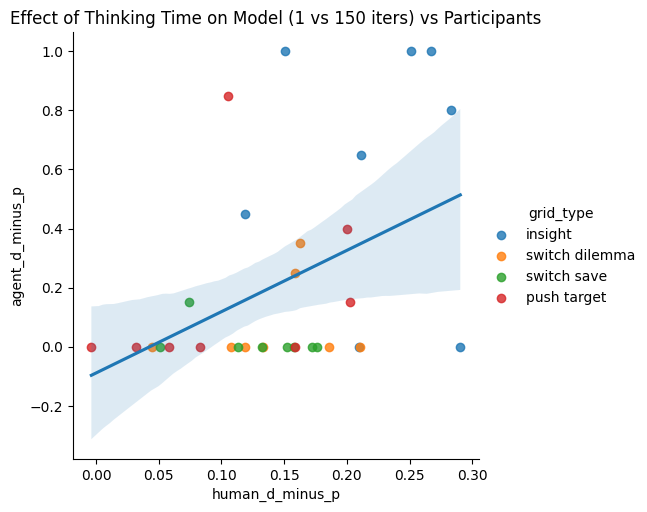

In [30]:
sns.lmplot(x='human_d_minus_p', y='agent_d_minus_p', data=corr_df, hue='grid_type', fit_reg=False)
ax = sns.regplot(x='human_d_minus_p', y='agent_d_minus_p', data=corr_df, scatter=False)
ax.set_title('Effect of Thinking Time on Model (1 vs 150 iters) vs Participants')
plt.show()

In [8]:
no_train_behav = pd.read_csv('/Users/hartleylabadmin/code/HartleyLab/dual_rl_final/data_analysis/data/training_experiment_raw.csv', encoding='utf-8-sig')

no_train_behav = no_train_behav[(no_train_behav['type']=='test') & (no_train_behav['step']==6) & (no_train_behav['timeout'] != '1')]
train_behav = no_train_behav[(no_train_behav['training']==1)]
no_train_behav = no_train_behav[(no_train_behav['training']==0)]
train_performance = train_behav.groupby("gridnum")['reward_cum'].mean()
no_train_performance = no_train_behav.groupby("gridnum")['reward_cum'].mean()
human_train_performance = pd.merge(train_performance, no_train_performance, right_index=True, left_index=True) 
human_train_performance = human_train_performance.rename(columns={"reward_cum_x": "training", "reward_cum_y": "no_training"})
human_train_performance['human_t_minus_nt'] = human_train_performance['training'] - human_train_performance['no_training']

In [9]:
ITERS = [1, 30, 70, 150]
REPEATS = 20 #number of times to redo the iteration for consistency

agent_train_scores = defaultdict(list)
agent_notrain_scores = defaultdict(list)
grid_order = []
agent = Agent()
for gridnum, grid in python_grids.items():
    best_reward = grid['best_reward']
    grid_order.append(gridnum)
    for i in ITERS:
        dual_score = 0
        mc_score = 0
        for j in range(REPEATS):
            testgrid = Grid(init_pos=grid)
            Q = agent.mc_first_visit_control(testgrid.copy(), iters=i, nn_init=True)
            reward = agent.run_final_policy(testgrid.copy(), Q, nn_init=True, display=False)
            dual_score += reward

            testgrid = Grid(init_pos=grid)
            Q = agent.mc_first_visit_control(testgrid.copy(), iters=i, nn_init=False)
            reward = agent.run_final_policy(testgrid.copy(), Q, nn_init=False, display=False)
            mc_score += reward

        agent_train_scores[i].append(dual_score/REPEATS)
        agent_notrain_scores[i].append(mc_score/REPEATS)

neural net loaded


In [10]:
agent_train_performance = pd.DataFrame(
    {'grid_num': grid_order,
     'train': agent_train_scores[1],
     'notrain': agent_notrain_scores[1]
    })

agent_train_performance['agent_t_minus_nt'] = agent_train_performance['train'] - agent_train_performance['notrain']
agent_train_performance
agent_train_performance['grid_type'] = agent_train_performance['grid_num'].apply(label)

In [14]:
corr_df = pd.merge(agent_train_performance,human_train_performance, left_on="grid_num", right_index=True)
corr_df = corr_df[["agent_t_minus_nt", "human_t_minus_nt","grid_num"]]
corr_df["grid_type"] = corr_df['grid_num'].apply(label)

pearson = scipy.stats.pearsonr(corr_df['human_t_minus_nt'], corr_df['agent_t_minus_nt']) 
spearman = scipy.stats.spearmanr(corr_df['human_t_minus_nt'], corr_df['agent_t_minus_nt'])  
print(pearson, spearman)

PearsonRResult(statistic=0.36614789508767037, pvalue=0.01451010492336839) SignificanceResult(statistic=0.3561342620008695, pvalue=0.01765876437078356)


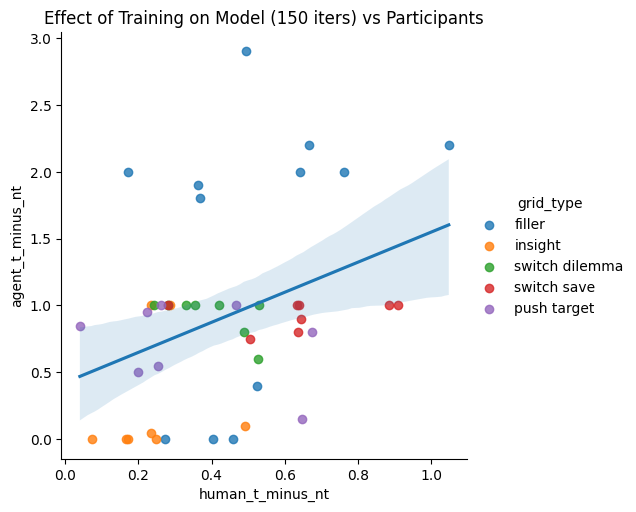

In [15]:
sns.lmplot(x='human_t_minus_nt', y='agent_t_minus_nt', data=corr_df, hue='grid_type', fit_reg=False)
ax = sns.regplot(x='human_t_minus_nt', y='agent_t_minus_nt', data=corr_df, scatter=False)
ax.set_title("Effect of Training on Model (150 iters) vs Participants")
plt.show()

In [44]:
lst = []
for gridnum, grid in python_grids.items():
    if gridnum > 100:
        testgrid = Grid(init_pos=grid)
        # todo document "get_is_action_of_interest"
        s, a, r, is_action_of_interest = get_true_Qs(testgrid.copy(), get_is_action_of_interest=True)
        for step in range(5):
            NN_output = neural_net.predict(s[step])[0]
            error = ((NN_output - a[step]) ** 2).mean(axis=0)
            accuracy = np.argmax(NN_output) in np.argwhere(a[step] == np.amax(a[step]))
            best_action_diff = np.average(NN_output[a[step] == np.amax(a[step])]) - np.amax(a[step])
            z_score = None
            if is_action_of_interest[step]:
                z_score = (NN_output[a[step] == np.amax(a[step])][0] - np.mean(NN_output)) / np.std(NN_output)
            lst.append([gridnum, step, error, accuracy, best_action_diff, is_action_of_interest[step], z_score])
df = pd.DataFrame(lst, columns = ['gridnum', 'step', 'error', 'accuracy', 'Signed Error', 'action of interest','z_score'])
df['Grid Type'] = df['gridnum'].apply(label)

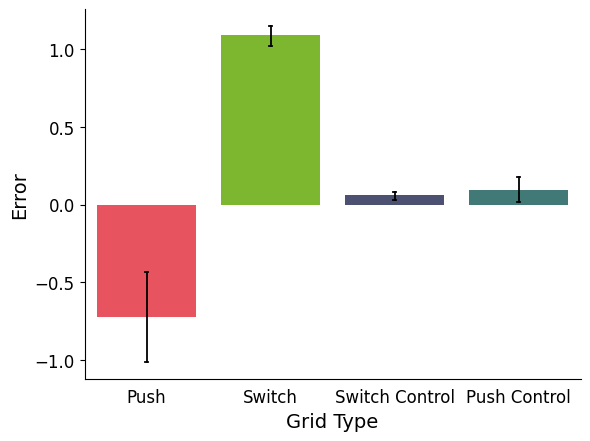

In [101]:
sns.reset_defaults()
color=['#FF3B4B', '#81CC18', '#464D77', '#36827F']
ax = sns.barplot(data=df[df['action of interest']==True], x="Grid Type", y="Signed Error", palette=color, capsize=0.03, errwidth=1.3, errcolor = 'black')
sns.despine()
plt.xlabel('Grid Type', fontsize=14)
plt.ylabel('Error', fontsize=14)
ax.tick_params(bottom=False, labelsize=12)
plt.show()

<Axes: title={'center': 'z-scored predicted Q values for action of interest'}, xlabel='gridtype', ylabel='z_score'>

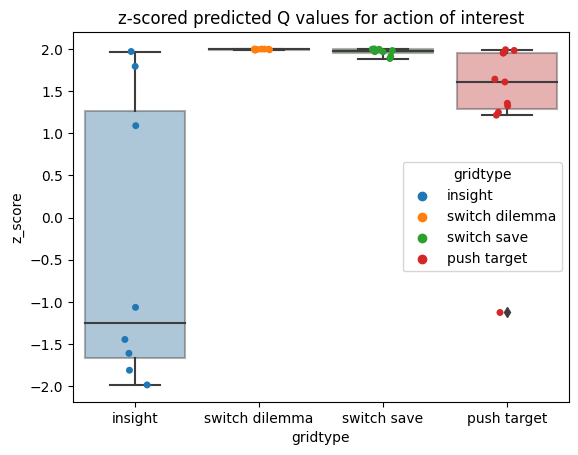

In [18]:
sns.boxplot(data=df[df['action of interest']==True],x='gridtype', y='z_score', boxprops={'alpha': 0.4}).set_title("z-scored predicted Q values for action of interest")
sns.stripplot(df[df['action of interest']==True],x='gridtype', y='z_score', hue='gridtype')

Text(0.5, 1.0, 'NN Step-by-Step MSError Per Gridtype')

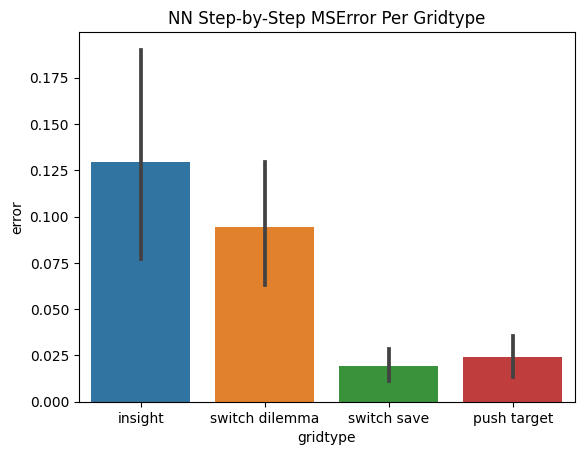

In [19]:
df.groupby('gridtype')['accuracy'].mean()
df.groupby('gridtype')['error'].mean()
sns.barplot(data=df, x="gridtype", y="error").set_title("NN Step-by-Step MSError Per Gridtype")

In [108]:
df_mean

,step,Grid Type,error
0,0,Push,0.323631
1,0,Push Control,0.054425
2,0,Switch,0.107818
3,0,Switch Control,0.050337
4,1,Push,0.167863
5,1,Push Control,0.031655
6,1,Switch,0.172270
7,1,Switch Control,0.032759
8,2,Push,0.128186
9,2,Push Control,0.018499


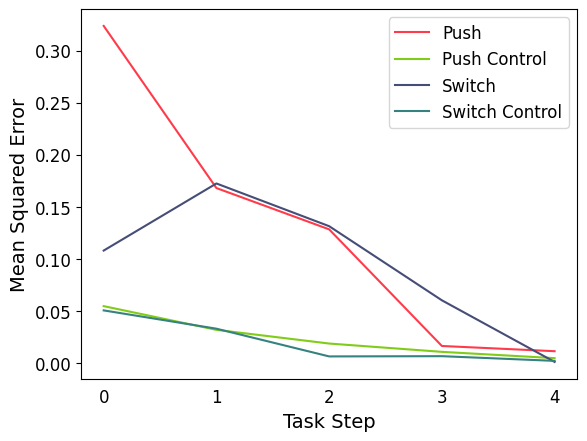

In [131]:
df_mean = df.groupby(['step','Grid Type'] ,as_index=False)['error'].mean()
ax = sns.lineplot(data = df_mean, x='step', y="error", hue="Grid Type", palette=color)
plt.xlabel('Task Step', fontsize=14)
plt.ylabel('Mean Squared Error', fontsize=14)
plt.legend(fontsize=12)
ax.tick_params(bottom=False, labelsize=12)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()